# 🏔️ Lakehouse Analysis with PySpark + Iceberg

This notebook demonstrates querying the Iceberg Lakehouse tables using PySpark.

## Medallion Architecture Layers
- **Bronze**: Raw events from Kafka (ingested by Flink)
- **Silver**: Cleaned, deduplicated facts and SCD Type 2 dimensions
- **Gold**: Aggregated metrics for BI/Analytics

## Prerequisites
Run the medallion flow test first:
```bash
docker exec spark-master /opt/spark/bin/spark-submit \
    --packages org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.5.0,org.apache.hadoop:hadoop-aws:3.3.4,com.amazonaws:aws-java-sdk-bundle:1.12.262 \
    --conf spark.extraListeners= \
    /opt/spark-jobs/test_medallion_flow.py
```


In [3]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

# Configure Spark for Iceberg using REST Catalog
# This connects to the same catalog used by Airflow DAGs
spark = SparkSession.builder \
    .appName("Lakehouse Analysis") \
    .config("spark.jars.packages", 
            "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.5.0,"
            "org.apache.iceberg:iceberg-aws-bundle:1.5.0") \
    .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
    .config("spark.sql.catalog.lakehouse", "org.apache.iceberg.spark.SparkCatalog") \
    .config("spark.sql.catalog.lakehouse.type", "rest") \
    .config("spark.sql.catalog.lakehouse.uri", "http://iceberg-rest:8181") \
    .config("spark.sql.catalog.lakehouse.warehouse", "s3://lakehouse/warehouse") \
    .config("spark.sql.catalog.lakehouse.io-impl", "org.apache.iceberg.aws.s3.S3FileIO") \
    .config("spark.sql.catalog.lakehouse.s3.endpoint", "http://minio:9000") \
    .config("spark.sql.catalog.lakehouse.s3.access-key-id", "minioadmin") \
    .config("spark.sql.catalog.lakehouse.s3.secret-access-key", "minioadmin123") \
    .config("spark.sql.catalog.lakehouse.s3.path-style-access", "true") \
    .config("spark.sql.catalog.lakehouse.client.region", "us-east-1") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin123") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print(f"✅ Spark version: {spark.version}")
print(f"📦 Iceberg catalog: lakehouse (REST @ http://iceberg-rest:8181)")
print(f"🪣 MinIO endpoint: http://minio:9000")


✅ Spark version: 3.5.0
📦 Iceberg catalog: lakehouse (REST @ http://iceberg-rest:8181)
🪣 MinIO endpoint: http://minio:9000


In [14]:
# List tables in each Medallion layer
for layer in ['bronze', 'silver', 'gold']:
    print(f"\n{'='*60}")
    print(f"📁 {layer.upper()} LAYER")
    print('='*60)
    try:
        tables = spark.sql(f"SHOW TABLES IN lakehouse.{layer}")
        if tables.count() == 0:
            print("   (no tables)")
        else:
            for row in tables.collect():
                table_name = f"lakehouse.{layer}.{row['tableName']}"
                count = spark.table(table_name).count()
                print(f"   └── {row['tableName']}: {count} rows")
    except Exception as e:
        print(f"   ❌ Error: {e}")



📁 BRONZE LAYER
   └── raw_conversion_events: 102 rows

📁 SILVER LAYER
   └── dim_users: 0 rows
   └── fact_conversions: 102 rows

📁 GOLD LAYER
   └── daily_conversion_summary: 1 rows
   └── popular_numbers: 100 rows
   └── user_metrics: 0 rows


📊 GOLD LAYER ANALYTICS

📅 Daily Conversion Summary:
+----------+-----------------+-----------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------------+
|event_date|total_conversions|total_numbers_converted|single_conversions|range_conversions|max_number_converted|min_number_converted|avg_response_time_ns|generated_at              |
+----------+-----------------+-----------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------------+
|2025-12-26|102              |102                    |102               |0                |2024                |1                   |69798.22549019608   |2025-12-27 00:14:19.843823|
+----------+-----------------+-----------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------------+


👥 User Metrics:
+-------+-----------

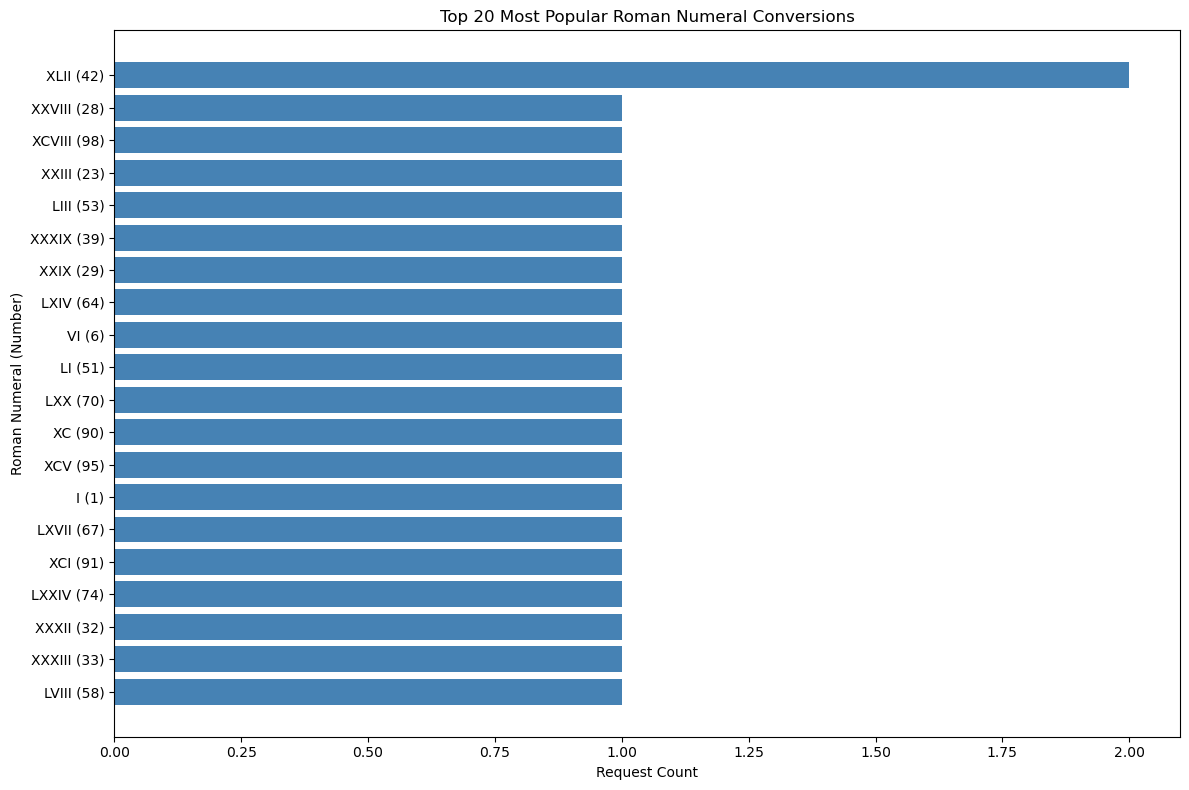

In [15]:
# Query Gold layer tables
print("📊 GOLD LAYER ANALYTICS")
print("="*60)

# Daily Summary
try:
    daily_df = spark.table("lakehouse.gold.daily_conversion_summary")
    print("\n📅 Daily Conversion Summary:")
    daily_df.show(truncate=False)
except Exception as e:
    print(f"❌ daily_conversion_summary: {e}")

# User Metrics
try:
    users_df = spark.table("lakehouse.gold.user_metrics")
    print("\n👥 User Metrics:")
    users_df.show(truncate=False)
except Exception as e:
    print(f"❌ user_metrics: {e}")

# Popular Numbers
try:
    popular_df = spark.table("lakehouse.gold.popular_numbers")
    print("\n🔥 Most Popular Numbers:")
    popular_df.show(truncate=False)
    
    # Visualization
    pdf = popular_df.toPandas()
    if len(pdf) > 0:
        # Take top 20 for cleaner visualization
        pdf_top = pdf.head(20)
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.barh(pdf_top['output_roman'].astype(str) + ' (' + pdf_top['input_number'].astype(str) + ')', 
                pdf_top['request_count'], color='steelblue')
        ax.set_xlabel('Request Count')
        ax.set_ylabel('Roman Numeral (Number)')
        ax.set_title('Top 20 Most Popular Roman Numeral Conversions')
        ax.invert_yaxis()  # Highest at top
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"❌ popular_numbers: {e}")


In [16]:
# 🔍 INTERESTING GOLD LAYER ANALYTICS
print("="*60)
print("🎯 ADVANCED ANALYTICS ON GOLD LAYER")
print("="*60)

# 1. What percentage of conversions are for numbers under 100?
print("\n📊 1. Distribution by Number Range:")
spark.sql("""
    SELECT 
        CASE 
            WHEN input_number <= 10 THEN '1-10 (Small)'
            WHEN input_number <= 100 THEN '11-100 (Medium)'
            WHEN input_number <= 1000 THEN '101-1000 (Large)'
            ELSE '1001-3999 (Very Large)'
        END as number_range,
        SUM(request_count) as total_requests,
        ROUND(SUM(request_count) * 100.0 / (SELECT SUM(request_count) FROM lakehouse.gold.popular_numbers), 2) as percentage
    FROM lakehouse.gold.popular_numbers
    GROUP BY 1
    ORDER BY MIN(input_number)
""").show()

# 2. Which Roman numerals have the most characters?
print("\n📏 2. Longest Roman Numerals Requested:")
spark.sql("""
    SELECT 
        input_number,
        output_roman,
        LENGTH(output_roman) as numeral_length,
        request_count
    FROM lakehouse.gold.popular_numbers
    ORDER BY LENGTH(output_roman) DESC, request_count DESC
    LIMIT 10
""").show(truncate=False)

# 3. "Round number" preference (multiples of 10, 100, etc.)
print("\n🎯 3. Round Number Preference:")
spark.sql("""
    SELECT 
        CASE 
            WHEN input_number % 100 = 0 THEN 'Multiple of 100'
            WHEN input_number % 50 = 0 THEN 'Multiple of 50'
            WHEN input_number % 10 = 0 THEN 'Multiple of 10'
            WHEN input_number % 5 = 0 THEN 'Multiple of 5'
            ELSE 'Other'
        END as number_type,
        COUNT(*) as unique_numbers,
        SUM(request_count) as total_requests
    FROM lakehouse.gold.popular_numbers
    GROUP BY 1
    ORDER BY total_requests DESC
""").show()

# 4. Numbers with repeated characters in Roman numerals (like III, XXX, CCC)
print("\n🔁 4. Numbers with Repeated Roman Numerals:")
spark.sql("""
    SELECT input_number, output_roman, request_count
    FROM lakehouse.gold.popular_numbers
    WHERE output_roman RLIKE '^(I{1,3}|V|X{1,3}|L|C{1,3}|D|M{1,3})$'
       OR output_roman IN ('III', 'XXX', 'CCC', 'MMM')
    ORDER BY request_count DESC
    LIMIT 10
""").show()

# 5. Average response time trends (if available in user_metrics)
print("\n⚡ 5. User Activity Summary:")
try:
    spark.sql("""
        SELECT 
            COUNT(*) as total_users,
            SUM(total_requests) as total_requests,
            ROUND(AVG(total_requests), 2) as avg_requests_per_user,
            MAX(total_requests) as max_requests_by_user
        FROM lakehouse.gold.user_metrics
    """).show()
except Exception as e:
    print(f"   (user_metrics not available: {e})")

print("\n✅ Analytics complete!")


🎯 ADVANCED ANALYTICS ON GOLD LAYER

📊 1. Distribution by Number Range:
+--------------------+--------------+----------+
|        number_range|total_requests|percentage|
+--------------------+--------------+----------+
|        1-10 (Small)|            10|      9.90|
|     11-100 (Medium)|            90|     89.11|
|1001-3999 (Very L...|             1|      0.99|
+--------------------+--------------+----------+


📏 2. Longest Roman Numerals Requested:
+------------+------------+--------------+-------------+
|input_number|output_roman|numeral_length|request_count|
+------------+------------+--------------+-------------+
|88          |LXXXVIII    |8             |1            |
|83          |LXXXIII     |7             |1            |
|78          |LXXVIII     |7             |1            |
|87          |LXXXVII     |7             |1            |
|38          |XXXVIII     |7             |1            |
|86          |LXXXVI      |6             |1            |
|89          |LXXXIX      |6    